In [17]:
#import
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import pairs_plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking

from ema_workbench.analysis import feature_scoring

In [81]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(5)
    scenarios=1000
    policies=4
    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=scenarios, policies=policies )

        experiments, outcomes = results

INFO | pool started with 7 workers
INFO | performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
100%|██████████████████████████████████████| 4000/4000 [03:29<00:00, 19.08it/s]
INFO | experiments finished
INFO | terminating pool


In [82]:
hri_sys = outcomes["A.2_Hydrological Resilience Index"].mean(axis=1)
hri_q25 = np.percentile(hri_sys, 25)# (N,) systeembreed
target_hri = hri_sys <= hri_q25

        # ---- 2.2 Expected Annual Damage ----
ead_total = outcomes["A.2_Expected Annual Damage"].sum(axis=1)  # (N,)
ead_q75 = np.percentile(ead_total, 75)
target_ead = ead_total >= ead_q75

        # # ---- 2.3 RfR Total Costs ----
        # rfr_costs = outcomes["RfR Total Costs"].sum(axis=1)  # (N,)
        # rfr_q75 = np.percentile(rfr_costs, 75)
        # target_rfr = rfr_costs >= rfr_q75

        # ---- 2.4 Combineer tot één worst-case target ----
y = target_hri | target_ead        # booleaanse vector (N,)
print(f"worst-cases: {y.sum()} van {scenarios*policies} runs  ({y.mean()*100:.1f} %)")

        #Determine model uncertainties
cols_unc = [u.name for u in model.uncertainties]
X = experiments[cols_unc]

#Start PRIM
prim_alg = prim.Prim(
            X, y,
            threshold=0.80,
        )

print("Aantal opgeslagen boxen:", len(prim_alg.boxes))



worst-cases: 1987 van 4000 runs  (49.7 %)
Aantal opgeslagen boxen: 1


INFO | 4000 points remaining, containing 1987 cases of interest
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '13.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
INFO | mean: 0.9716981132075472, mass: 0.053, coverage: 0.10367388022143935, density: 0.9716981132075472 restricted_dimensions: 6


coverage      0.103674
density       0.971698
id           53.000000
k           206.000000
mass          0.053000
mean          0.971698
n           212.000000
res_dim       6.000000
Name: 53, dtype: float64

                                  box 53                             \
                                     min              max  qp value   
A.2_pfail                       0.000191         0.091138       NaN   
A.4_Bmax                       30.203064       313.896168       NaN   
discount rate 0          {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.015259   
A.1_Bmax                       47.689077        331.24766  0.346029   
A.3_Bmax                       39.465322       329.977307  0.364600   
A.0_ID flood wave shape               14              132  0.486429   

                                       
                             qp value  
A.2_pfail                6.871446e-52  
A.4_Bmax                 2.651917e-01  
discount rate 0                   NaN  
A.1_Bmax             

/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 2.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


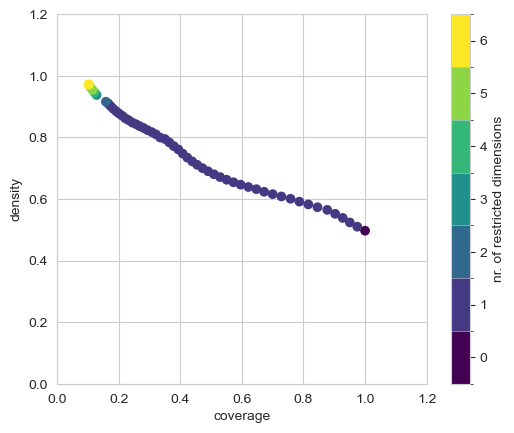

54 stappen in deze box


In [83]:
# A) De “beste” box volgens je threshold
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()
plt.show()# geeft een PrimBox terug
traj = box.peeling_trajectory
print(len(traj), "stappen in deze box")

[<Figure size 640x480 with 1 Axes>]

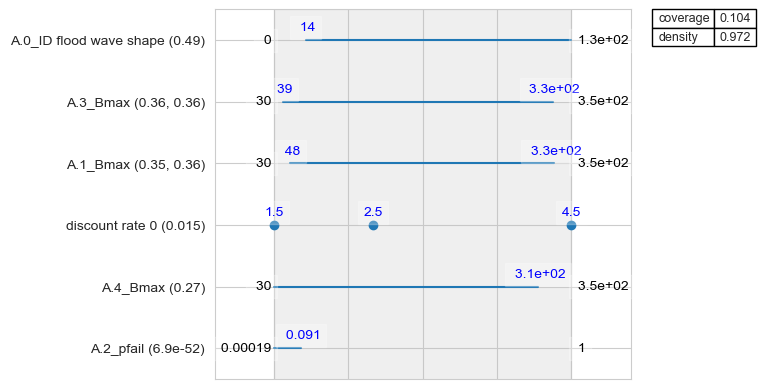

In [84]:
# spring naar stap 5 van de peeling/pasting-traj
box.select(53)

# en inspecteer 'm meteen
box.inspect( style="graph" )

Beste trade-off zit in box #3
coverage    0.927529
density     0.538259
res_dim     1.000000
score       0.499251
Name: 3, dtype: float64
coverage       0.927529
density        0.538259
id             3.000000
k           1843.000000
mass           0.856000
mean           0.538259
n           3424.000000
res_dim        1.000000
Name: 3, dtype: float64

              box 3                                 
                min       max qp value      qp value
A.2_pfail  0.000191  0.855849      NaN  6.405492e-07



[<Figure size 640x480 with 1 Axes>]

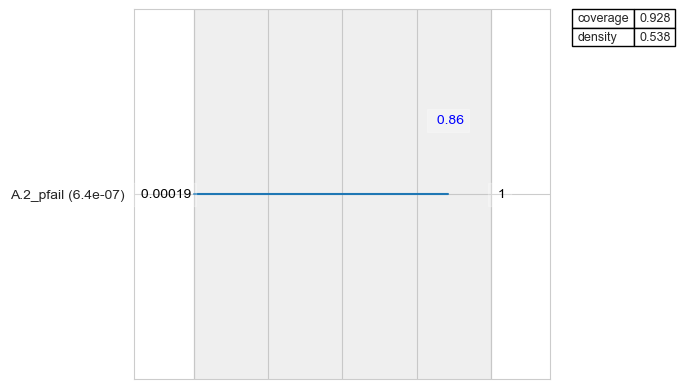

In [91]:
# 1. haal de peeling‐trajectory op
traj = box.peeling_trajectory

# 2. bereken voor elke stap een trade-off‐score
#    hier: product van coverage en density
traj = traj.copy()
traj["score"] = traj["coverage"] * traj["density"]

# 3. vind de index van de maximale score
best_idx = traj["score"].idxmax()

# 4. pak daar de bijbehorende box-id
best_box_id = int(traj.loc[best_idx, "id"])
print(f"Beste trade-off zit in box #{best_box_id}")
print(traj.loc[best_idx, ["coverage", "density", "res_dim", "score"]])

# 5. laad en inspecteer die box|
box.select(best_box_id)
box.inspect()
box.inspect(style="graph")

coverage      0.103674
density       0.971698
id           53.000000
k           206.000000
mass          0.053000
mean          0.971698
n           212.000000
res_dim       6.000000
Name: 53, dtype: float64

                                  box 53                             \
                                     min              max  qp value   
A.2_pfail                       0.000191         0.091138       NaN   
A.4_Bmax                       30.203064       313.896168       NaN   
discount rate 0          {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.015259   
A.1_Bmax                       47.689077        331.24766  0.346029   
A.3_Bmax                       39.465322       329.977307  0.364600   
A.0_ID flood wave shape               14              132  0.486429   

                                       
                             qp value  
A.2_pfail                6.871446e-52  
A.4_Bmax                 2.651917e-01  
discount rate 0                   NaN  
A.1_Bmax             

/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 2.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


[<Figure size 640x480 with 1 Axes>]

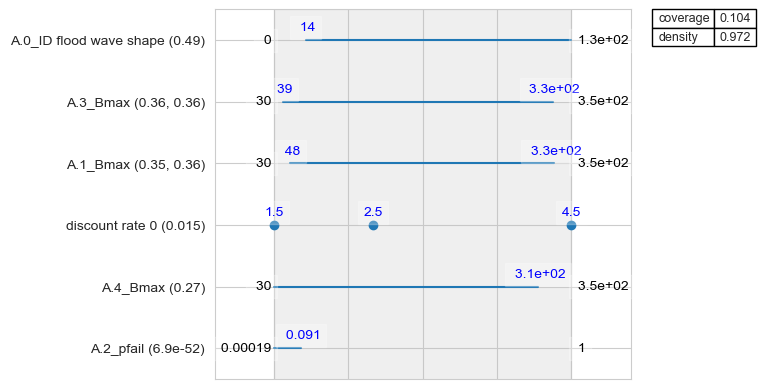

In [100]:
box.select(53)
box.inspect()
box.inspect(style="graph")

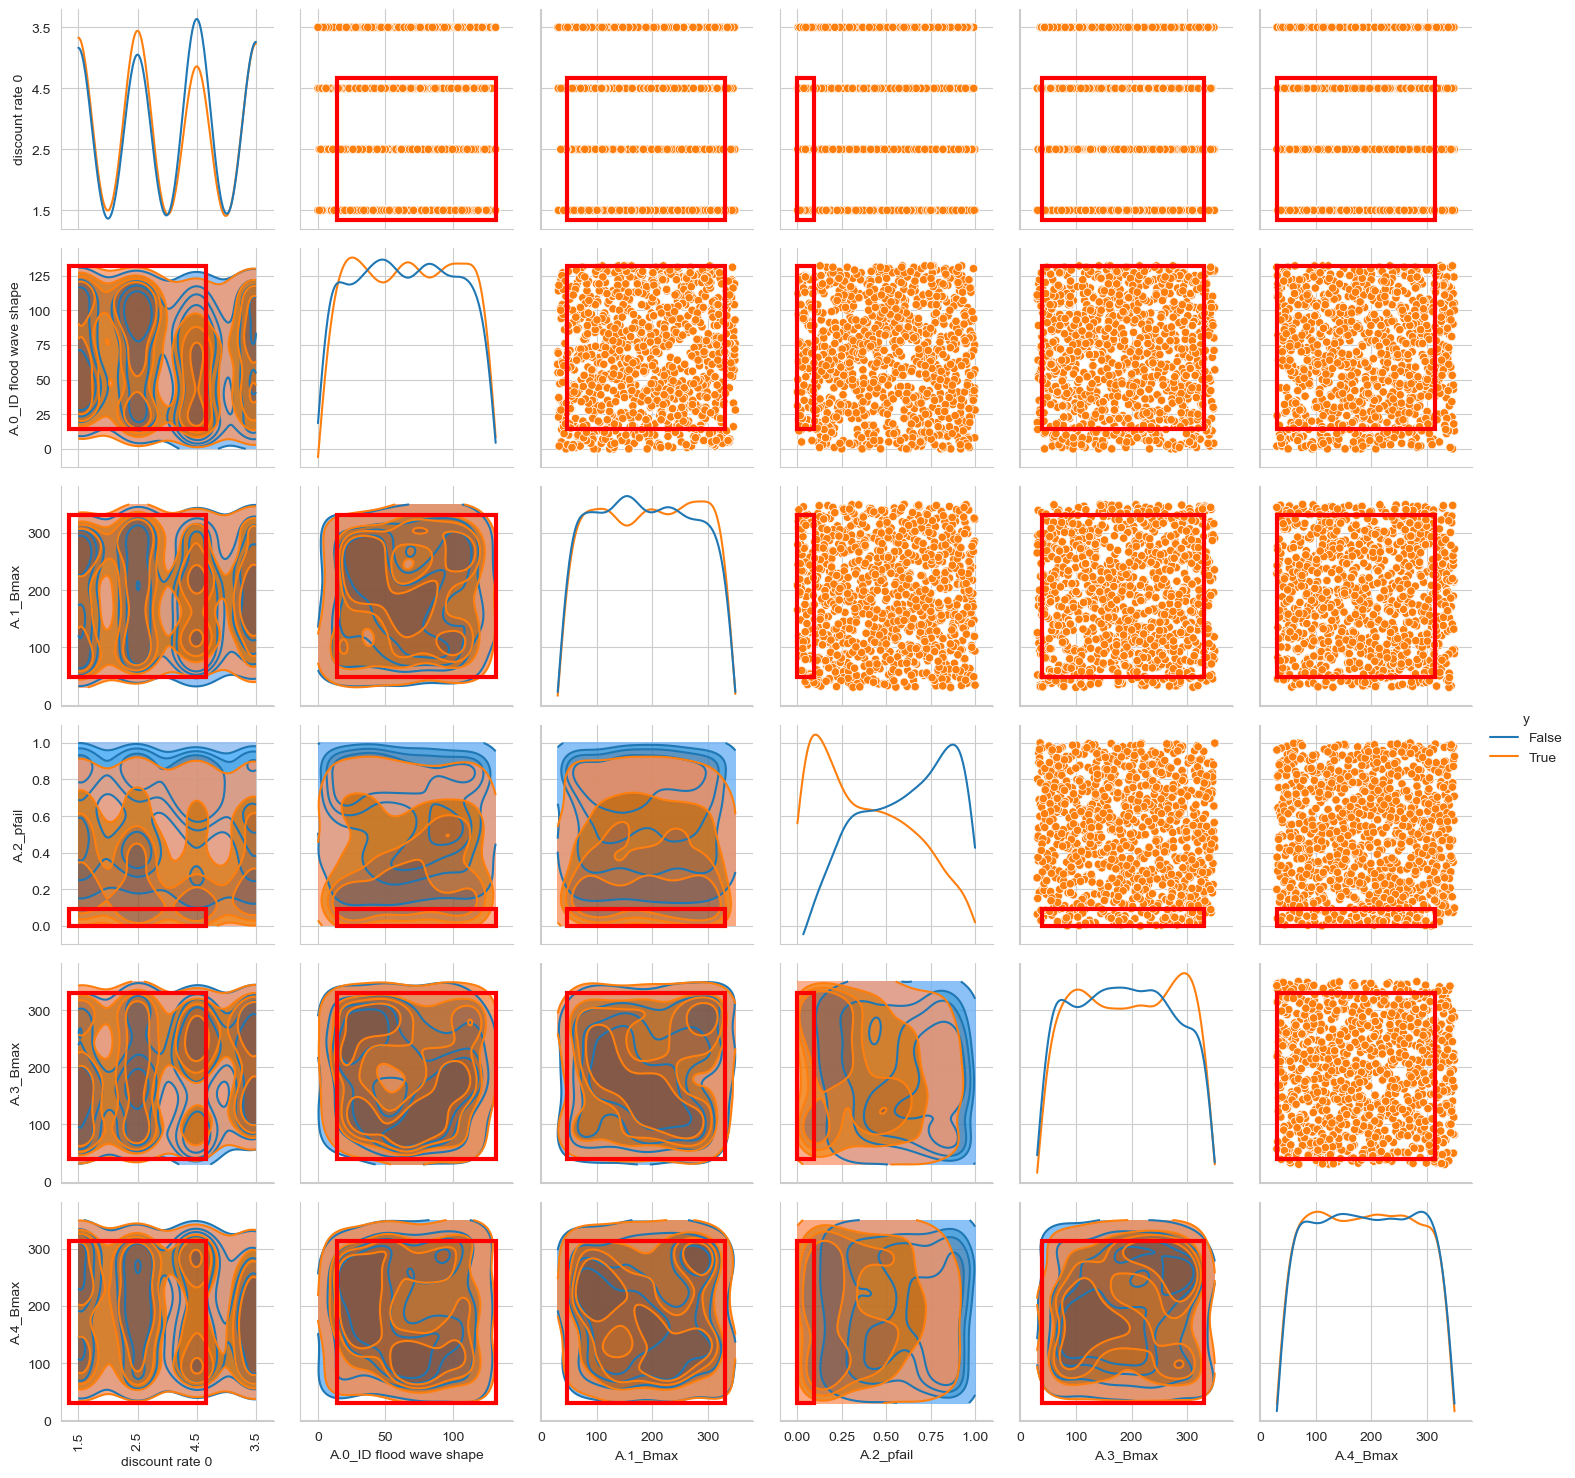

In [101]:
fig = box.show_pairs_scatter()
plt.show()

INFO | model dropped from analysis because only a single category


origineel aantal kolommen: 53
zonder levers           : 22


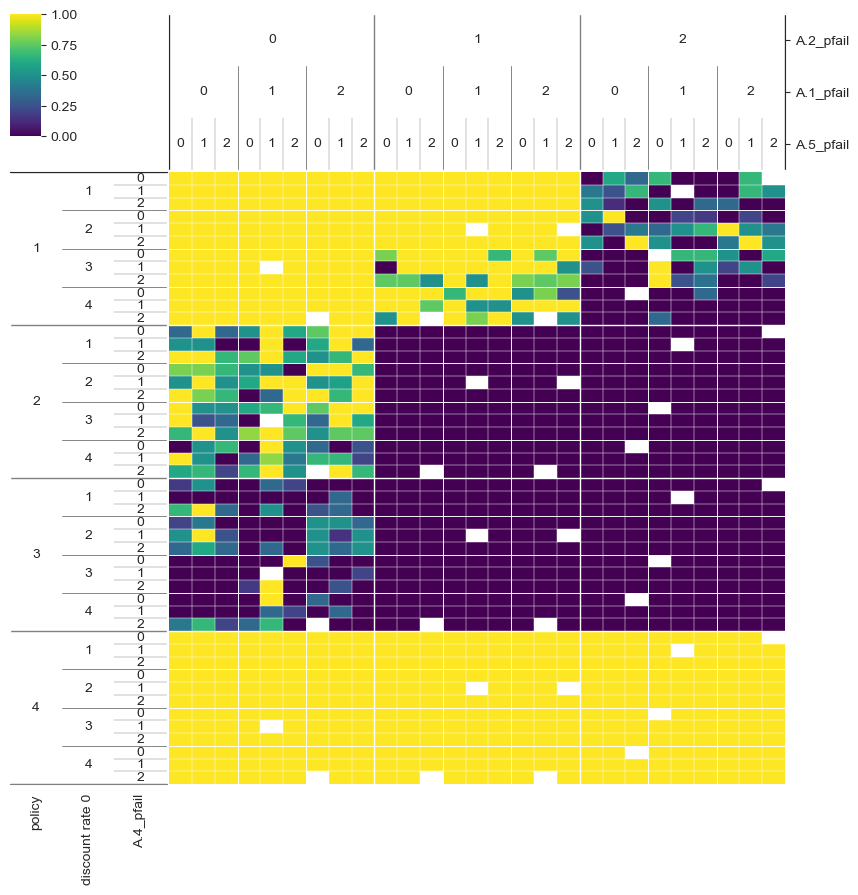

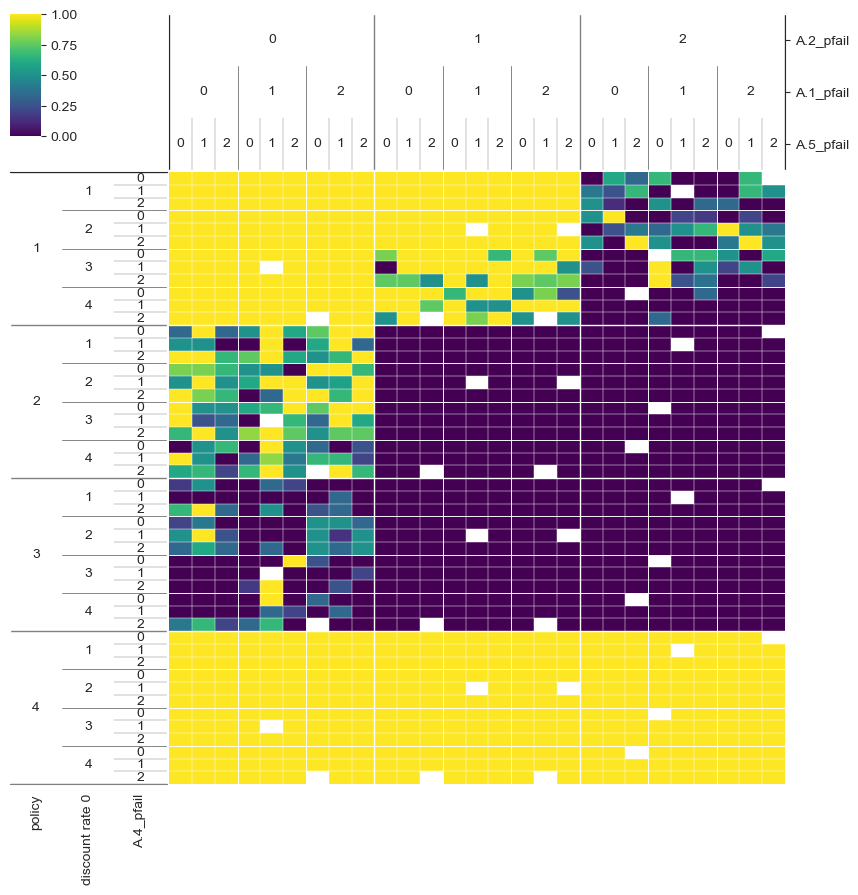

In [89]:
lever_names = [lev.name for lev in model.levers]
experiments_unc = experiments.drop(columns=lever_names)


# even checken:
print("origineel aantal kolommen:", experiments.shape[1])
print("zonder levers           :", experiments_unc.shape[1])

dimensional_stacking.create_pivot_plot(experiments_unc, y)
